# Parte 1 – Propensão de inadimplência (2,5)

 Implementar em contêiner o modelo propensão de inadimplência desenvolvido na disciplina de Estatística utilizando a linguagem R ou Python.

 1. Treinar um modelo de propensão à inadimplência em R ou em Python, como visto nas aulas de estatística. (0,50)

  Nota: A API só precisa retornar a propensão à inadimplência. A criação de um modelo "fake" que retorna aleatoriamente 0 ou 1 apenas desabona esse 0,50 ponto.

2. Servir o modelo por uma API como as vistas em aula. (0,50)
  
  Nas aulas utilizamos Python + Flask, será necessário utilizar outra tecnologia, por exemplo: R + Plumber

3. Encapsular o modelo em um contêiner (1,50).– O Contêiner deve apenas receber os parâmetros de entrada e retornar a propensão da inadimplência

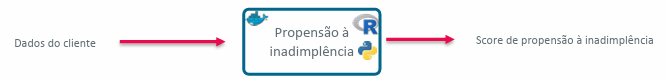

## 1- Treinar um modelo de propensão à inadimplência em R ou em Python

Obs.: A implementação desse notebook foi feita em R. Deve-se trocar o Runtime Type antes de iniciar as execuções

### Instalações

In [1]:
# Instalação de pacotes:
install.packages("plumber")
install.packages("bigrquery")
install.packages("caret")
install.packages("car")
install.packages("ROCR")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘later’, ‘Rcpp’, ‘webutils’, ‘httpuv’, ‘promises’, ‘sodium’, ‘swagger’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘clock’, ‘rapidjsonr’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘lme4’


Installing package into ‘/usr/local/lib/R/site-libr

### Bibliotecas

In [2]:
library(bigrquery)
library(caret)
library(ggplot2)
library(dplyr)
library(car)
library(ROCR)
library(plumber)

Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode




### Conexão com o Big Query

In [4]:
# Solicitar ao usuário o Project ID
# Utilizei o meu projeto para teste (rm347975)
project_id <- readline("Digite o Project ID do Google Cloud: ")

# Execute a consulta no BigQuery
query <- "SELECT * FROM `emf-teacher.trabalho_loans.loan_default`"
result <- bq_table_download(bq_project_query(project_id, query))

# Converta o resultado em um data frame
loans_data_orig <- as.data.frame(result)

Digite o Project ID do Google Cloud: rm347975


Is it OK to cache OAuth access credentials in the folder ~/.cache/gargle
between R sessions?
1: Yes
2: No


Selection: 1


Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=1100b3b841f40feacef923e573292950&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQWZKb2hYbEY1ZlY1V2YtOXZjQ1ZrMFhHTThpN2R6SjRZREFQbFJFTkFDdllrYmVNS0lKcUZjYzVPMGZJNUg1QVlZNm5UZyIsInN0YXRlIjoiMTEwMGIzYjg0MWY0MGZlYWNlZjkyM2U1NzMyOTI5NTAifQ==


In [5]:
head(loans_data_orig)
loans_data <- loans_data_orig

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,⋯,credit_type,Credit_Score,co_applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<int>,<dbl>
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,⋯,EQUI,552,EXP,55-64,to_inst,NA,North,direct,1,NA
2,24932,2019,cf,Male,nopre,type3,p4,l1,nopc,nob/c,⋯,EQUI,765,EXP,45-54,to_inst,NA,North,direct,1,NA
3,25039,2019,cf,Male,nopre,type2,p3,l1,nopc,b/c,⋯,EQUI,880,EXP,35-44,to_inst,NA,North,direct,1,NA
4,25101,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,⋯,EQUI,880,EXP,45-54,to_inst,NA,central,direct,1,NA
5,25110,2019,cf,Male,nopre,type3,p3,l1,nopc,nob/c,⋯,EQUI,768,EXP,45-54,not_inst,NA,North,direct,1,NA
6,25131,2019,cf,Male,nopre,type1,p3,l1,nopc,nob/c,⋯,EQUI,571,EXP,>74,to_inst,NA,North,direct,1,NA


In [6]:
# Converter a variável Status para categórica
loans_data$Status <- factor(loans_data$Status, levels = c(0, 1), labels = c("0", "1"))

# Verificar o resultado
str(loans_data$Status)

 Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...


### Preparação dos dados

In [7]:
# Resumo das informações das variáveis
summary(loans_data)

       ID              year       loan_limit           Gender         
 Min.   : 24890   Min.   :2019   Length:148670      Length:148670     
 1st Qu.: 62057   1st Qu.:2019   Class :character   Class :character  
 Median : 99224   Median :2019   Mode  :character   Mode  :character  
 Mean   : 99224   Mean   :2019                                        
 3rd Qu.:136392   3rd Qu.:2019                                        
 Max.   :173559   Max.   :2019                                        
                                                                      
 approv_in_adv       loan_type         loan_purpose       Credit_Worthiness 
 Length:148670      Length:148670      Length:148670      Length:148670     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                               

In [8]:
print(paste("Número de linhas Original: ", nrow(loans_data)))

[1] "Número de linhas Original:  148670"


In [9]:
# Verificar a quantidade de valores nulos em cada coluna
missing_values <- colSums(is.na(loans_data))

# Exibir o data frame
# missing_values_df <- data.frame(Coluna = names(missing_values), Nulos = missing_values)
missing_values_df <- data.frame(Nulos = missing_values)
print(missing_values_df)

                          Nulos
ID                            0
year                          0
loan_limit                 3344
Gender                        0
approv_in_adv               908
loan_type                     0
loan_purpose                134
Credit_Worthiness             0
open_credit                   0
business_or_commercial        0
loan_amount                   0
rate_of_interest          36439
Interest_rate_spread      36639
Upfront_charges           39642
term                         41
Neg_ammortization           121
interest_only                 0
lump_sum_payment              0
property_value            15098
construction_type             0
occupancy_type                0
Secured_by                    0
total_units                   0
income                     9150
credit_type                   0
Credit_Score                  0
co_applicant_credit_type      0
age                         200
submission_of_application     0
LTV                       15098
Region  

In [10]:
# Remover linhas onde as colunas categóricas são nulas
loans_data <- subset(loans_data, !is.na(loan_limit))
loans_data <- subset(loans_data, !is.na(approv_in_adv))
loans_data <- subset(loans_data, !is.na(loan_purpose))
loans_data <- subset(loans_data, !is.na(Neg_ammortization))
loans_data <- subset(loans_data, !is.na(age))

In [11]:
# Substituindo os valores nulos da coluna rate_of_interest (MEDIANA)
median_rate <- median(loans_data$rate_of_interest, na.rm = TRUE)
loans_data$rate_of_interest <- ifelse(is.na(loans_data$rate_of_interest), median_rate, loans_data$rate_of_interest)

# Substituindo os valores nulos da coluna Interest_rate_spread (MEDIANA)
median_rate <- median(loans_data$Interest_rate_spread, na.rm = TRUE)
loans_data$Interest_rate_spread <- ifelse(is.na(loans_data$Interest_rate_spread), median_rate, loans_data$Interest_rate_spread)

# Substituindo os valores nulos da coluna Upfront_charges (MEDIANA)
median_rate <- median(loans_data$Upfront_charges, na.rm = TRUE)
loans_data$Upfront_charges <- ifelse(is.na(loans_data$Upfront_charges), median_rate, loans_data$Upfront_charges)

# Substituindo os valores nulos da coluna term (MEDIANA)
median_rate <- median(loans_data$term, na.rm = TRUE)
loans_data$term <- ifelse(is.na(loans_data$term), median_rate, loans_data$term)

# Substituindo os valores nulos da coluna property_value (MEDIANA)
median_rate <- median(loans_data$property_value, na.rm = TRUE)
loans_data$property_value <- ifelse(is.na(loans_data$property_value), median_rate, loans_data$property_value)

# Substituindo os valores nulos da coluna income (MEDIANA)
median_rate <- median(loans_data$income, na.rm = TRUE)
loans_data$income <- ifelse(is.na(loans_data$income), median_rate, loans_data$income)

# Substituindo os valores nulos da coluna LTV (MEDIANA)
median_rate <- median(loans_data$LTV, na.rm = TRUE)
loans_data$LTV <- ifelse(is.na(loans_data$LTV), median_rate, loans_data$LTV)

# Substituindo os valores nulos da coluna dtir1 (MEDIANA)
median_rate <- median(loans_data$dtir1, na.rm = TRUE)
loans_data$dtir1 <- ifelse(is.na(loans_data$dtir1), median_rate, loans_data$dtir1)

In [12]:
# Verificar quais colunas têm valores nulos
colunas_nulas <- colnames(loans_data)[colSums(is.na(loans_data)) > 0]

# Exibir os nomes das colunas com valores nulos
print(paste("Colunas com valores nulos: ", colunas_nulas))
print(paste("Número de linhas Final: ", nrow(loans_data)))

[1] "Colunas com valores nulos:  "
[1] "Número de linhas Final:  143983"


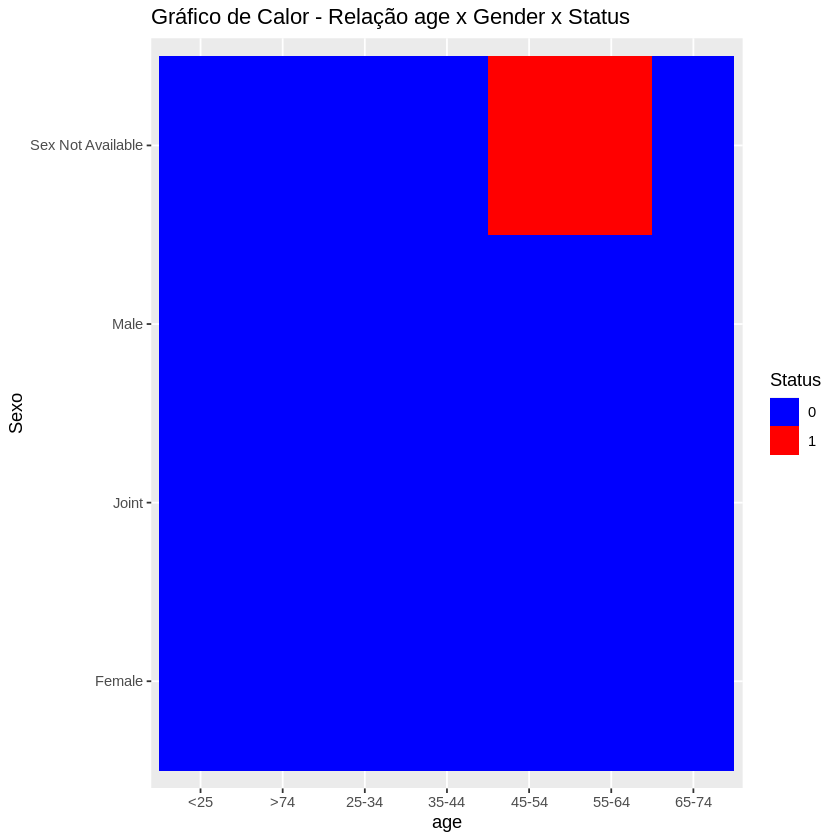

In [13]:
# Gráficos de calor - análise Gender x “age” x Status
ggplot(data = loans_data, aes(x = age, y = Gender, fill = factor(Status))) +
  geom_tile() +
  scale_fill_manual(values = c("0" = "blue", "1" = "red")) +
  labs(x = "age", y = "Sexo", fill = "Status", title = "Gráfico de Calor - Relação age x Gender x Status")

*Verificamos nesta análise que temos incidencia de inadiplência (coluna Status = 1) em pessoas com idade em 45 a 64 anos, onde o sexo (Gender) não foi informado (Sex Not Available).*

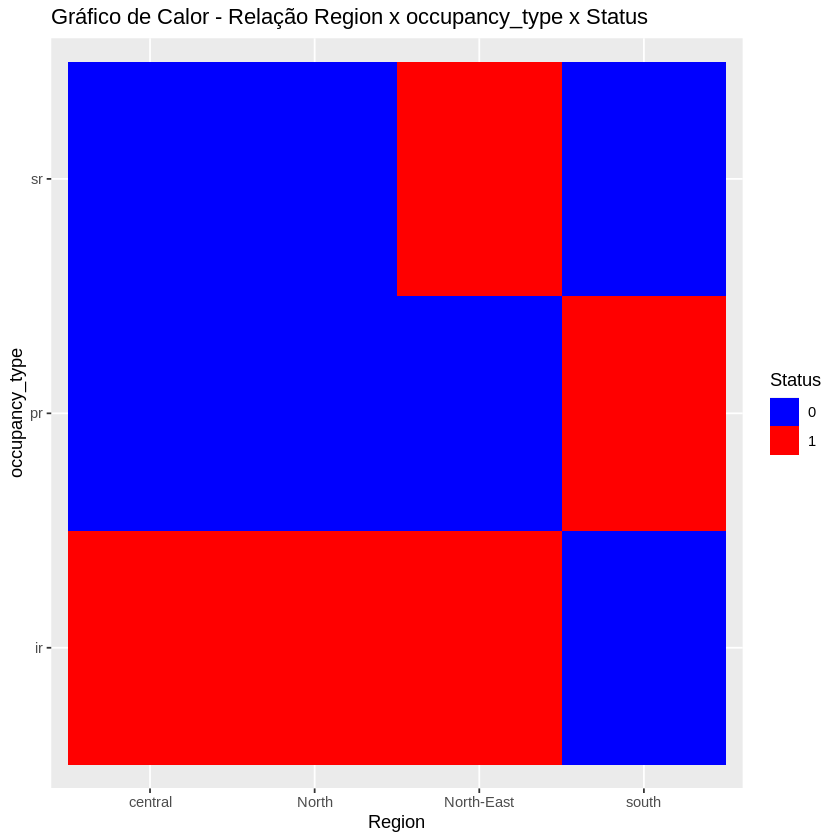

In [14]:
# Gráficos de calor - análise occupancy_type x Region x Status
ggplot(data = loans_data, aes(x = Region, y = occupancy_type, fill = factor(Status))) +
  geom_tile() +
  scale_fill_manual(values = c("0" = "blue", "1" = "red")) +
  labs(x = "Region", y = "occupancy_type", fill = "Status", title = "Gráfico de Calor - Relação Region x occupancy_type x Status")

*Neste caso é possível identificar que a maior incidência de inadimplência é de pessoas com occupation_type = 'ir', que não moram na região sul.*

### Treino do modelo - Regressão Logística

In [15]:
nomes_features <- c("loan_limit",       "Gender",                    "approv_in_adv",
                    "loan_type",        "loan_purpose",              "Credit_Worthiness",
                    "open_credit",      "business_or_commercial",    "loan_amount",
                    "rate_of_interest", "Interest_rate_spread",      "Upfront_charges",
                    "term",             "Neg_ammortization",         "interest_only",
                    "lump_sum_payment", "property_value",            "construction_type",
                    "occupancy_type",   "total_units",               "income",
                    "credit_type",      "Credit_Score",              "co_applicant_credit_type",
                    "age",              "submission_of_application", "LTV",
                    "Region",           "dtir1")
formula <- as.formula(paste("Status ~", paste(nomes_features, collapse = " + ")))

# Criação do modelo
modelo_rlog <- glm(formula, data = loans_data, family = 'binomial')
summary(modelo_rlog)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = formula, family = "binomial", data = loans_data)

Coefficients: (1 not defined because of singularities)
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       1.898e+01  8.009e+01   0.237 0.812696    
loan_limitncf                     7.438e-01  3.195e-02  23.276  < 2e-16 ***
GenderJoint                      -1.348e-02  3.462e-02  -0.389 0.697061    
GenderMale                        1.212e-01  2.455e-02   4.935 8.01e-07 ***
GenderSex Not Available           2.462e-02  3.150e-02   0.782 0.434377    
approv_in_advpre                 -2.174e-01  2.431e-02  -8.941  < 2e-16 ***
loan_typetype2                    5.920e-01  2.827e-02  20.944  < 2e-16 ***
loan_typetype3                   -1.082e+00  3.400e-02 -31.819  < 2e-16 ***
loan_purposep2                    1.060e+00  5.604e-02  18.910  < 2e-16 ***
loan_purposep3                    4.329e-01  2.600e-02  16.648  < 2e-16 ***
loan_purposep4                   -7.93

In [16]:
# Visualizar os coeficientes do modelo
coeficientes <- coef(modelo_rlog)
print(coeficientes)

                     (Intercept)                    loan_limitncf 
                    1.897665e+01                     7.437653e-01 
                     GenderJoint                       GenderMale 
                   -1.347657e-02                     1.211739e-01 
         GenderSex Not Available                 approv_in_advpre 
                    2.462131e-02                    -2.174006e-01 
                  loan_typetype2                   loan_typetype3 
                    5.920008e-01                    -1.081912e+00 
                  loan_purposep2                   loan_purposep3 
                    1.059780e+00                     4.328657e-01 
                  loan_purposep4              Credit_Worthinessl2 
                   -7.933170e-03                     4.706087e-01 
                  open_creditopc      business_or_commercialnob/c 
                   -8.880368e-02                               NA 
                     loan_amount                 rate_of_inter

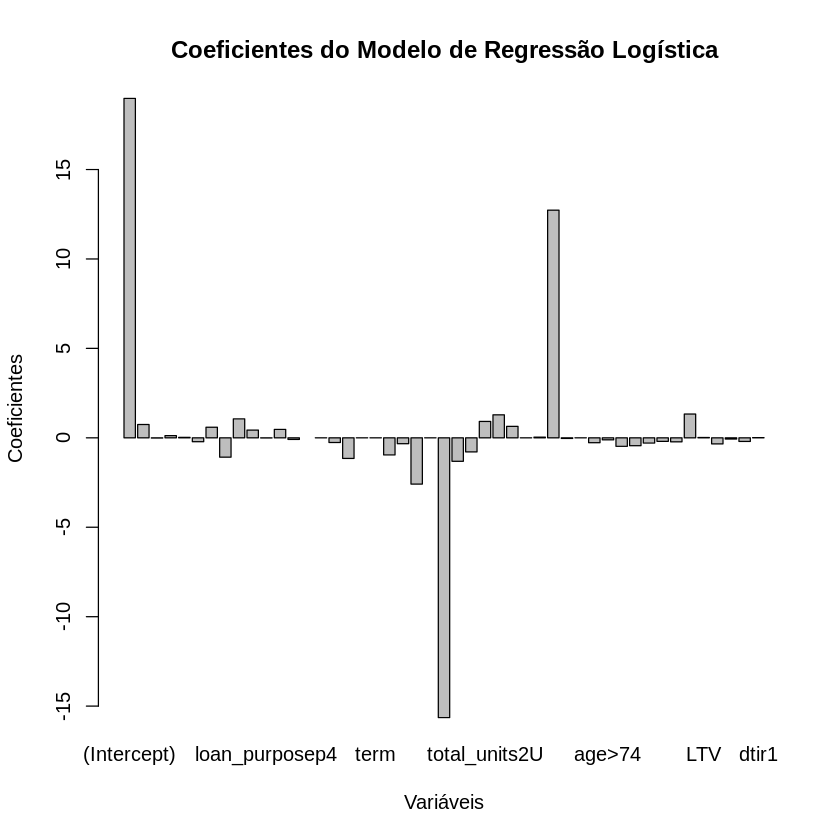

In [17]:
# Plotar os coeficientes do modelo
barplot(coeficientes, main = "Coeficientes do Modelo de Regressão Logística",
        xlab = "Variáveis", ylab = "Coeficientes")

In [18]:
# Removendo algumas variáveis para evitar o overfiting
nomes_features <- c("loan_limit",               "approv_in_adv",        "loan_type",
                    "loan_purpose",             "Credit_Worthiness",     "Interest_rate_spread",
                    "Neg_ammortization",        "interest_only",         "lump_sum_payment",
                    "occupancy_type",           "total_units",           "credit_type",
                    "co_applicant_credit_type", "age",                   "submission_of_application", "Region")
formula <- as.formula(paste("Status ~", paste(nomes_features, collapse = " + ")))

# Criação do modelo
modelo_rlog <- glm(formula, data = loans_data, family = 'binomial')
summary(modelo_rlog)


Call:
glm(formula = formula, family = "binomial", data = loans_data)

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       3.30893    0.11501  28.771  < 2e-16 ***
loan_limitncf                     0.66578    0.02911  22.870  < 2e-16 ***
approv_in_advpre                 -0.20532    0.02387  -8.601  < 2e-16 ***
loan_typetype2                    1.14688    0.02300  49.862  < 2e-16 ***
loan_typetype3                   -0.44509    0.03010 -14.786  < 2e-16 ***
loan_purposep2                    0.55341    0.05172  10.700  < 2e-16 ***
loan_purposep3                    0.09081    0.02374   3.825 0.000131 ***
loan_purposep4                   -0.09713    0.02387  -4.070 4.71e-05 ***
Credit_Worthinessl2               0.40155    0.03683  10.903  < 2e-16 ***
Interest_rate_spread             -1.13184    0.02250 -50.293  < 2e-16 ***
Neg_ammortizationnot_neg         -0.98595    0.02273 -43.375  < 2e-16 ***
interest_onlynot_int       

In [19]:
#método stepwise (AIC)
modelofinal_rlog <- step(modelo_rlog)

Start:  AIC=100967
Status ~ loan_limit + approv_in_adv + loan_type + loan_purpose + 
    Credit_Worthiness + Interest_rate_spread + Neg_ammortization + 
    interest_only + lump_sum_payment + occupancy_type + total_units + 
    credit_type + co_applicant_credit_type + age + submission_of_application + 
    Region

                            Df Deviance    AIC
<none>                           100903 100967
- interest_only              1   100954 101016
- approv_in_adv              1   100979 101041
- age                        6   100994 101046
- Credit_Worthiness          1   101015 101077
- Region                     3   101032 101090
- total_units                3   101041 101099
- loan_purpose               3   101105 101163
- loan_limit                 1   101384 101446
- co_applicant_credit_type   1   101484 101546
- occupancy_type             2   101486 101546
- Neg_ammortization          1   102632 102694
- submission_of_application  1   103255 103317
- loan_type               

In [20]:
# Obtendo Betas
beta <- modelofinal_rlog$coefficients
ICbeta <- confint.default(modelofinal_rlog, level = 0.95)
print(ICbeta)

                                        2.5 %      97.5 %
(Intercept)                       3.083519521  3.53434382
loan_limitncf                     0.608719406  0.72283580
approv_in_advpre                 -0.252105790 -0.15852711
loan_typetype2                    1.101798959  1.19196130
loan_typetype3                   -0.504085936 -0.38609180
loan_purposep2                    0.452041104  0.65477889
loan_purposep3                    0.044281388  0.13733989
loan_purposep4                   -0.143902957 -0.05034906
Credit_Worthinessl2               0.329367990  0.47373747
Interest_rate_spread             -1.175951944 -1.08773482
Neg_ammortizationnot_neg         -1.030503160 -0.94139977
interest_onlynot_int             -0.338517461 -0.19509317
lump_sum_paymentnot_lpsm         -2.703761550 -2.51288911
occupancy_typepr                 -0.992637592 -0.84841609
occupancy_typesr                 -0.733928664 -0.48225680
total_units2U                     0.581135839  0.85759742
total_units3U 

In [21]:
# Obtendo OR (ODDs Ratio)
OR <- exp(beta)
print(OR)

                     (Intercept)                    loan_limitncf 
                    2.735588e+01                     1.946003e+00 
                approv_in_advpre                   loan_typetype2 
                    8.143896e-01                     3.148355e+00 
                  loan_typetype3                   loan_purposep2 
                    6.407673e-01                     1.739173e+00 
                  loan_purposep3                   loan_purposep4 
                    1.095062e+00                     9.074417e-01 
             Credit_Worthinessl2             Interest_rate_spread 
                    1.494143e+00                     3.224383e-01 
        Neg_ammortizationnot_neg             interest_onlynot_int 
                    3.730841e-01                     7.658222e-01 
        lump_sum_paymentnot_lpsm                 occupancy_typepr 
                    7.365779e-02                     3.983091e-01 
                occupancy_typesr                    total_unit

In [22]:
# Obtendo  IC95% (Intervalo de Confiança)
IC <- exp(ICbeta)
print(IC)

                                        2.5 %       97.5 %
(Intercept)                      2.183512e+01 3.427252e+01
loan_limitncf                    1.838076e+00 2.060267e+00
approv_in_advpre                 7.771625e-01 8.533998e-01
loan_typetype2                   3.009575e+00 3.293534e+00
loan_typetype3                   6.040575e-01 6.797081e-01
loan_purposep2                   1.571517e+00 1.924717e+00
loan_purposep3                   1.045276e+00 1.147218e+00
loan_purposep4                   8.659718e-01 9.508974e-01
Credit_Worthinessl2              1.390089e+00 1.605985e+00
Interest_rate_spread             3.085251e-01 3.369789e-01
Neg_ammortizationnot_neg         3.568274e-01 3.900814e-01
interest_onlynot_int             7.128263e-01 8.227580e-01
lump_sum_paymentnot_lpsm         6.695319e-02 8.103378e-02
occupancy_typepr                 3.705979e-01 4.280925e-01
occupancy_typesr                 4.800194e-01 6.173885e-01
total_units2U                    1.788068e+00 2.357490e+

In [23]:
# Formatando a saída, para uma melhor análise
smr <- summary((modelofinal_rlog))
RESULTADO <- data.frame(beta, OR, IC, p.value = smr$coefficients[,4])
RESULTADO <- round(RESULTADO, 3)
colnames(RESULTADO)[3:4] <- c("IC2.5", "IC97.5")
RESULTADO

,beta,OR,IC2.5,IC97.5,p.value
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),3.309,27.356,21.835,34.273,0.000
loan_limitncf,0.666,1.946,1.838,2.060,0.000
approv_in_advpre,-0.205,0.814,0.777,0.853,0.000
loan_typetype2,1.147,3.148,3.010,3.294,0.000
loan_typetype3,-0.445,0.641,0.604,0.680,0.000
loan_purposep2,0.553,1.739,1.572,1.925,0.000
loan_purposep3,0.091,1.095,1.045,1.147,0.000
loan_purposep4,-0.097,0.907,0.866,0.951,0.000
Credit_Worthinessl2,0.402,1.494,1.390,1.606,0.000


In [24]:
# Verificando a qualidade das variáveis do modelo pelo VIF (multicolinearidade)
VIF <- modelofinal_rlog %>% vif() %>% data.frame()
names(VIF) <- c("VIF")
VIF$VAR <- rownames(VIF)
VIF <- VIF[,c(2, 1)]
VIF

,NA,VIF
,<dbl>,<dbl>
loan_limit,1,1.029358
approv_in_adv,1,1.083927
loan_type,2,1.468144
loan_purpose,3,1.395535
Credit_Worthiness,1,1.016276
Interest_rate_spread,1,1.602175
Neg_ammortization,1,1.026218
interest_only,1,1.012910
lump_sum_payment,1,1.019951


*Como todas as variáveis apresentaram VIF < 5, é adequado mantê-las no modelo.*

In [25]:
fit_rlog <- modelofinal_rlog
score = predict(fit_rlog, loans_data, type = "response")
pred <- ROCR::prediction(score, loans_data[[names(fit_rlog$model)[[1]]]])
perf <- ROCR::performance(pred, "tpr", "fpr")

In [26]:
ks <-  max(attr(perf, 'y.values')[[1]] - attr(perf, 'x.values')[[1]])
auc <- ROCR::performance(pred, measure = "auc")
auc <- auc@y.values[[1]]

In [27]:
# Obtendo os valores de análise de performance do modelo (KS: Kolmogorov-Smirnov e AUC: Área Sob a Curva)
result <- data.frame("Resultados" = deparse(substitute(df)),
                     KS = round(ks, 2),
                     AUC = round(auc, 2))
colnames(result)[[1]] <- "Base de Dados"

result

Base de Dados,KS,AUC
<chr>,<dbl>,<dbl>
df,0.55,0.83


*Em resumo, um KS de 0.59 e uma AUC de 0.86 sugerem que o seu modelo tem uma capacidade razoável de discriminar entre as classes positivas e negativas. Esses valores são bastante bons, especialmente se estiver lidando com um problema de classificação binária.*

In [28]:
# Lógica para medir a acurácia:
set.seed(123)

# Separar os dados em conjuntos de treino (80%) e teste (20%)
indice_treino <- createDataPartition(loans_data$Status, p = 0.8, list = FALSE)
dados_treino <- loans_data[indice_treino, ]
dados_teste <- loans_data[-indice_treino, ]

predicoes <- predict(modelofinal_rlog, newdata = dados_teste, type = "response")
rotulos_preditos <- ifelse(predicoes > 0.5, 1, 0)  # Aqui usamos 0.5 como limiar, podendo ser ajustado se necessário
rotulos_reais <- dados_teste$Status

# Calcular acurácia
acuracia <- sum(rotulos_preditos == rotulos_reais) / length(rotulos_reais)

print(paste("Acurácia: ", acuracia))

[1] "Acurácia:  0.86484233921378"


In [29]:
# Salvar o modelo treinado em um arquivo .RData
save(modelofinal_rlog, file = "/content/modelo_rlog.RData")

### Testando o modelo com dados previamente selecionados

In [30]:
# Criar função para a API
predict_api <- function(novos_dados) {
  # O nome do modelo deve ser exatamente como ele estava sendo chamado ao ser salvo (não é o nome do arquivo)
  previsoes <- predict(modelofinal_rlog, novos_dados, type = "response")
  return(previsoes)
}

In [31]:
# Selecionando alguma das linhas do dataframe
linha_subset <- loans_data[11300, nomes_features]

# Exibindo o resultado
print(linha_subset)

      loan_limit approv_in_adv loan_type loan_purpose Credit_Worthiness
11711         cf         nopre     type1           p4                l1
      Interest_rate_spread Neg_ammortization interest_only lump_sum_payment
11711               0.6039           not_neg       not_int         not_lpsm
      occupancy_type total_units credit_type co_applicant_credit_type   age
11711             pr          1U        CRIF                      CIB 35-44
      submission_of_application Region
11711                   to_inst  North


In [32]:
# Efetuando a predição
predict_api(linha_subset)

11711 
0.1047037

## 2- Servir o modelo por uma API como as vistas em aula.

### Criação da API Plumber

#### Tentativa pelo Google Colab

Foi criado um arquivo api_script.R, no qual está implementada a predição, considerando que o arquivo do modelo treinado foi salvo na pasta "/content/modelo_rlog.RData".
É necessário subir esse arquivo no Colab, junto ao arquivo do modelo.RData

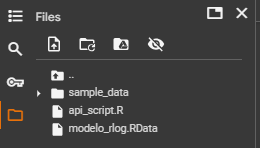

Segue abaixo o conteúdo de tal arquivo:



```
# Carregar o modelo
load("./modelo_rlog.RData")

# Criar função para a API
#' @post /predict
#' Prever resultados usando o modelo treinado
#' @param novos_dados Dados para fazer a previsão
#' @return Lista com as previsões

predict_api <- function(features) {
  # Efetuando a previsão, utilizando o modelofinal_rlog
  previsoes <- predict(modelofinal_rlog, features, type = "response")
  return(list(previsoes = previsoes))
}
```



In [ ]:
# Criar um objeto plumber
r_api <- plumb("api_script.R")

# Definir o endpoint para a função predict_api
r_api$run(port = 9000)

Deve-se executar a célula acima, onde a API ficaria disponível para ser utilizada.

URI: http://127.0.0.1:9000/predict_api

Exemplo de payload:
```
{
    "novos_dados": {
        "loan_limit": "cf",
        "approv_in_adv": "nopre",
        "loan_type": "type3",
        "loan_purpose": "p4",
        "Credit_Worthiness": "l1",
        "Interest_rate_spread": 0.39,
        "Neg_ammortization": "not_neg",
        "interest_only": "not_int",
        "lump_sum_payment": "lpsm",
        "occupancy_type": "ir",
        "total_units": "1U",
        "credit_type": "CRIF",
        "co_applicant_credit_type": "EXP",
        "age": "25-34",
        "submission_of_application": "to_inst",
        "Region": "North"
    }
}
```

Executei a chamada da API no Postman, porém obtive mensagem de erro "Error: connect ECONNREFUSED". Pelo que pude verificar em pesquisa, o Google Colab tem algumas particularidades, o que impede criar diretamente a API (seria necessária a utilização de outras ferramentas). Segue abaixo evidência da execução com erro:

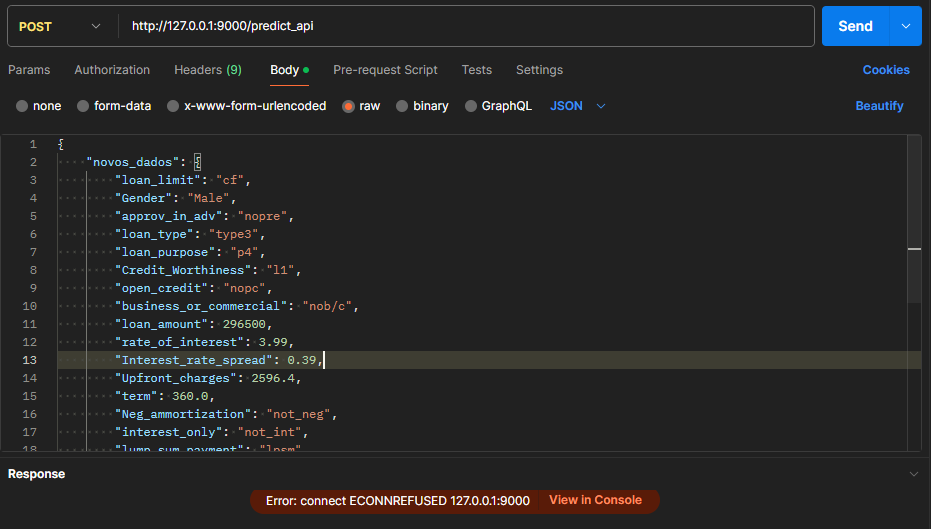

#### Tentativa pelo R Studio

Foi implementado o arquivo "Montagem API.R" no R Studio.

Código-fonte:

```
# Instalar e carregar o pacote plumber
install.packages("plumber")
library(plumber)
library(rstudioapi)

# Criar um objeto plumber
r_api <- plumb(file.path(dirname(getActiveDocumentContext()$path), 'api_script.R'))
  
# Definir o endpoint para a função predict_api
r_api$run(port = 9000)
```
Da mesma forma que na tentativa anterior, temos que ter em mãos o arquivo "api_script.R". Apenas uma ressalva quanto à esse arquivo, a pasta onde o modelo está salvo deve ser ajustado também.

Executando o "api_script.R" no R Studio, temos agora a API disponível.

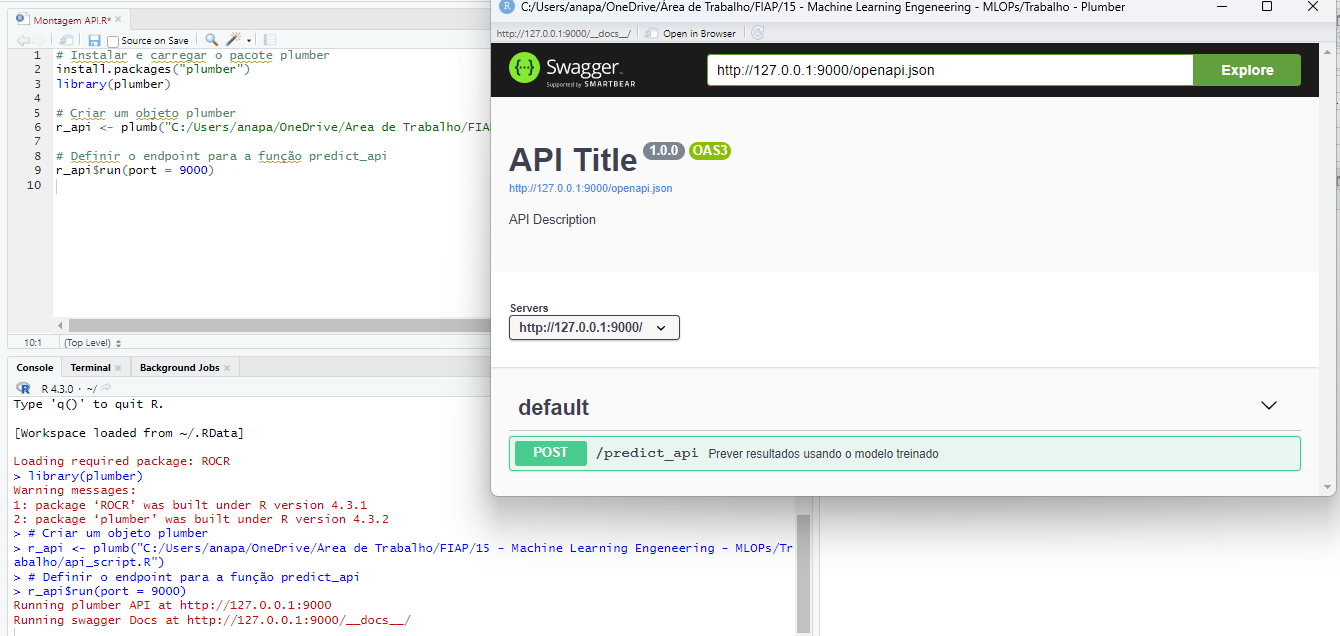

Segue abaixo a evidência de execução no Postman.

Obs.: Foi utilizada a mesma URI e mesmo Payload citados na tentativa anterior.

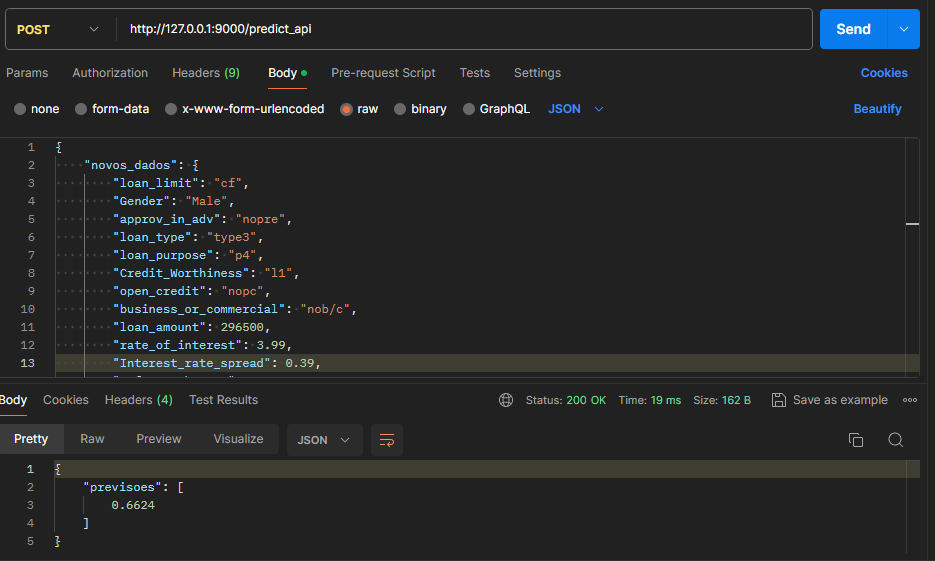

## 3- Encapsular o modelo em um contêiner

Para este caso, devido aos conhecimentos que tivemos em aula, optamos por substituir essa API feita em R, por uma similar, feita em Python.
Sua documentação completa está no arquivo **MLOPS_Trabalho_Integrado_Parte_1_Python.ipynb**